# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil

C:\Users\niels\AppData\Local\Temp\ipykernel_32364\671109650.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Settings

In [2]:
path = "D:\\AI\\Random\\Random"

# Load Data

In [3]:
df = pd.DataFrame([])
for file in os.listdir(path):
    if file.endswith(".csv"):
        df = pd.concat([df, pd.read_csv(os.path.join(path, file))], ignore_index=True)

In [4]:
colsn2plot = ['symmetry_incl1', 'symmetry_incl2',
       'symmetry_incl3', 'symmetry_incl4', 'symmetry_excl1', 'symmetry_excl2',
       'symmetry_excl3', 'symmetry_excl4', "id_string", "experiment_id", "generation_index", "individual_index"]
columns2plot = list(df.columns)
for col in colsn2plot:
    if col in columns2plot:
        columns2plot.remove(col)

# Create Repository

In [ ]:
# Remove and create a subdirectory
if os.path.exists(f"{path}//Morphology//ScatterPlots"):
    shutil.rmtree(f"{path}//Morphology//ScatterPlots")
os.makedirs(f"{path}Morphology//ScatterPlots")

# Remove and create a subdirectory
if os.path.exists(f"{path}//Morphology//Histograms"):
    shutil.rmtree(f"{path}//Morphology//Histograms")
os.makedirs(f"{path}//Morphology//Histograms")

# Remove and create a subdirectory
if os.path.exists(f"{path}//Morphology//ScatterUnique"):
    shutil.rmtree(f"{path}//Morphology//ScatterUnique")
os.makedirs(f"{path}//Morphology//ScatterUnique//log")
os.makedirs(f"{path}//Morphology//ScatterUnique//nonlog")

# Generate Scatter Plot

In [6]:
# # Columns to plot
# cols2plot = [col for col in df.columns if col not in ["id_string", "count"]]
# # Plot
# for icol1, col1 in enumerate(cols2plot):
#     for col2 in cols2plot[icol1 + 1:]:
#         if col1 != col2:
#             print(f"Saving: {col1}_{col2}")
#             plt.scatter(df[col1], df[col2])
#             plt.xlabel(col1, fontsize = 16, fontweight = "bold")
#             plt.ylabel(col2, fontsize = 16, fontweight = "bold")
#             plt.grid()
#             plt.savefig(f"Morphology/Scatterplots/{col1}_{col2}.png")
#             plt.close()

# Violin Plots

D:\AI\Random\Random\Morphologies\plots\violin\all\bricks.png


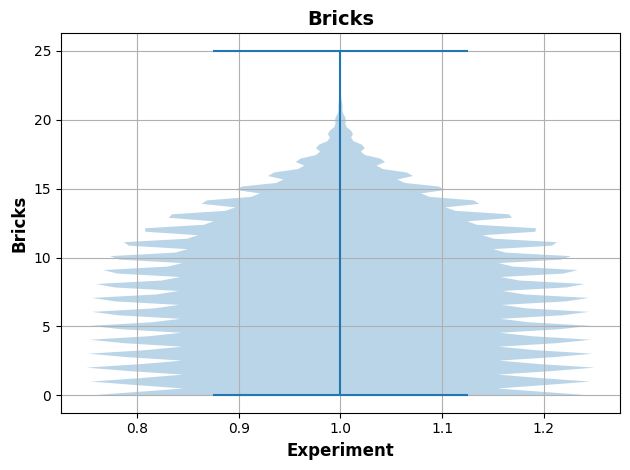

D:\AI\Random\Random\Morphologies\plots\violin\all\hinges.png


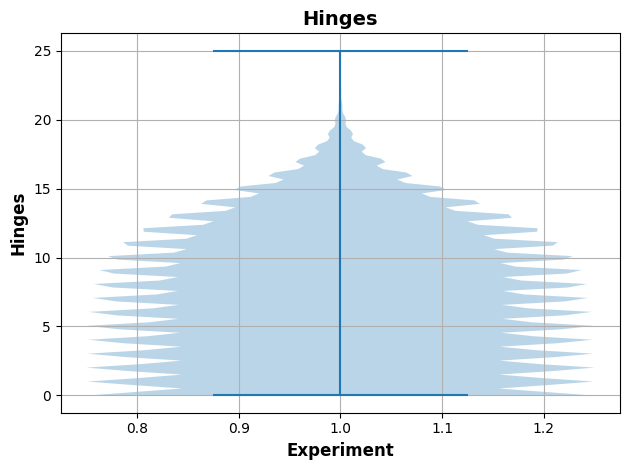

D:\AI\Random\Random\Morphologies\plots\violin\all\modules.png


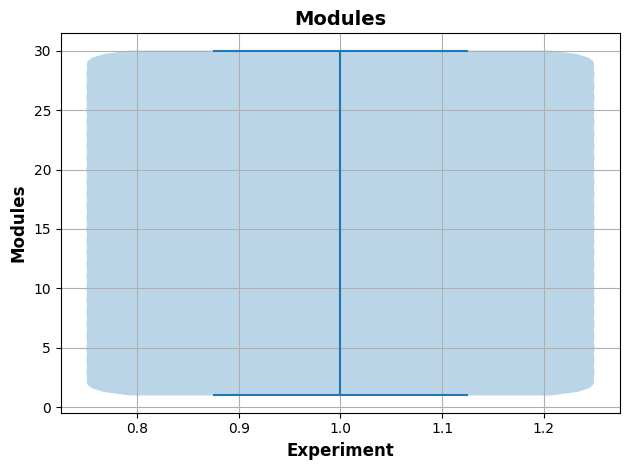

D:\AI\Random\Random\Morphologies\plots\violin\all\size.png


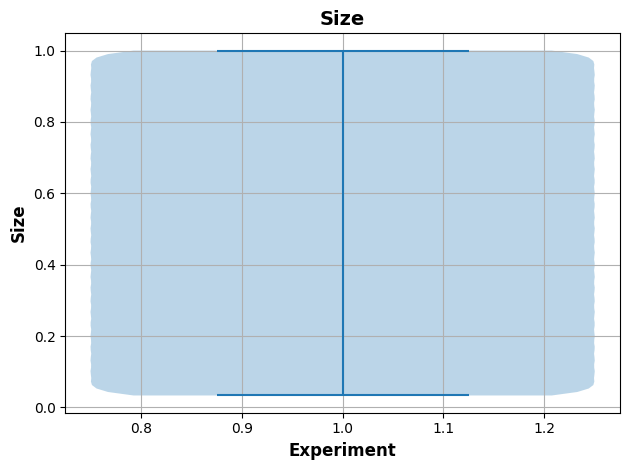

D:\AI\Random\Random\Morphologies\plots\violin\all\proportion2d.png


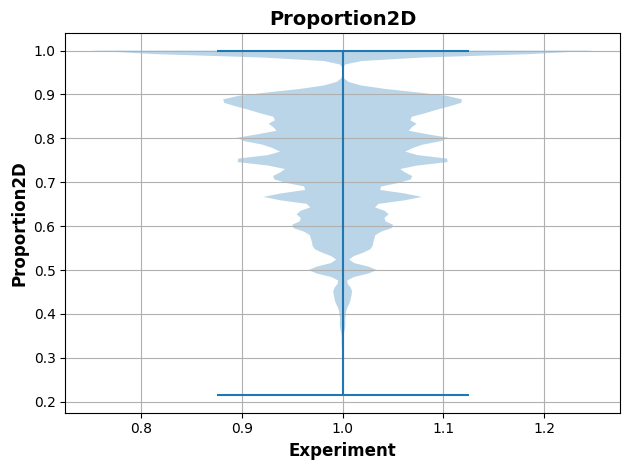

D:\AI\Random\Random\Morphologies\plots\violin\all\proportionNiels.png


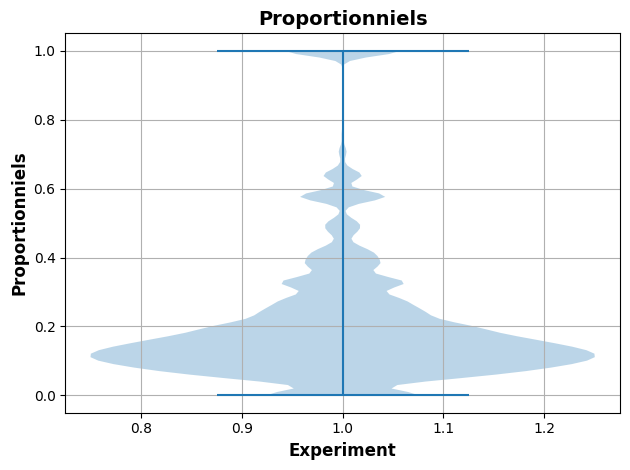

D:\AI\Random\Random\Morphologies\plots\violin\all\single_neighbour_brick_ratio.png


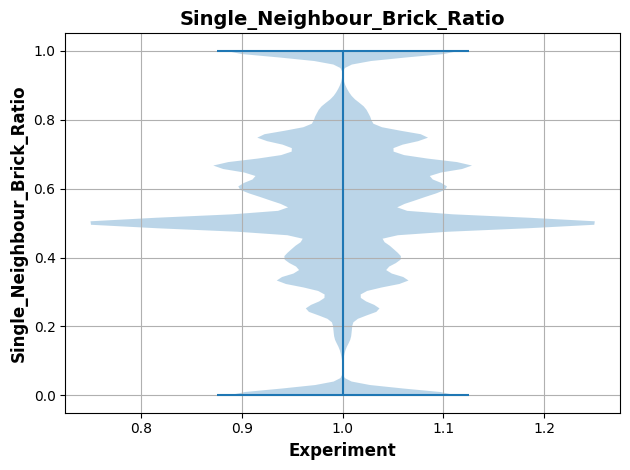

D:\AI\Random\Random\Morphologies\plots\violin\all\single_neighbour_ratio.png


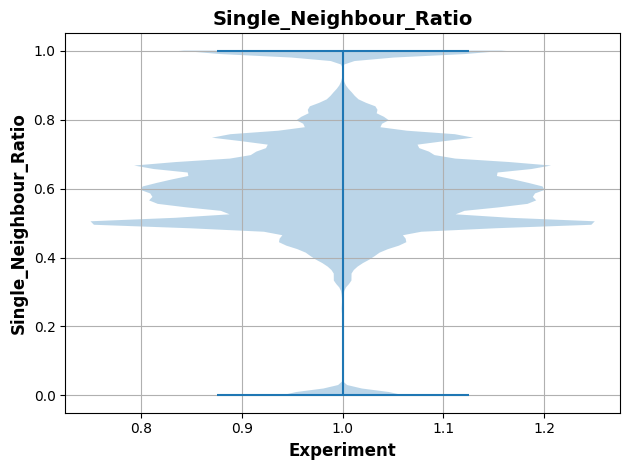

D:\AI\Random\Random\Morphologies\plots\violin\all\double_neighbour_brick_and_active_hinge_ratio.png


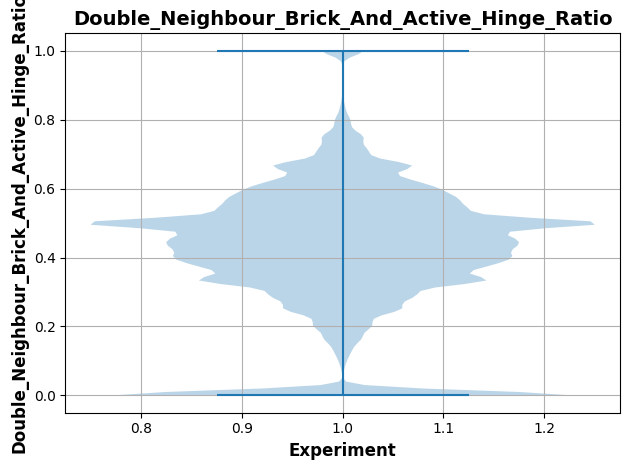

D:\AI\Random\Random\Morphologies\plots\violin\all\maxrel_llimbs.png


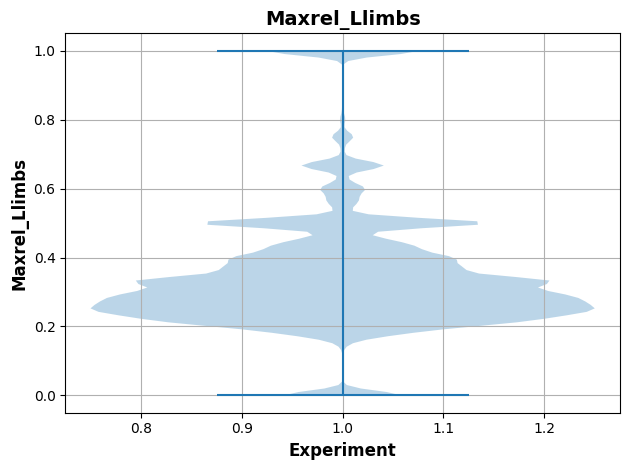

D:\AI\Random\Random\Morphologies\plots\violin\all\meanrel_llimbs.png


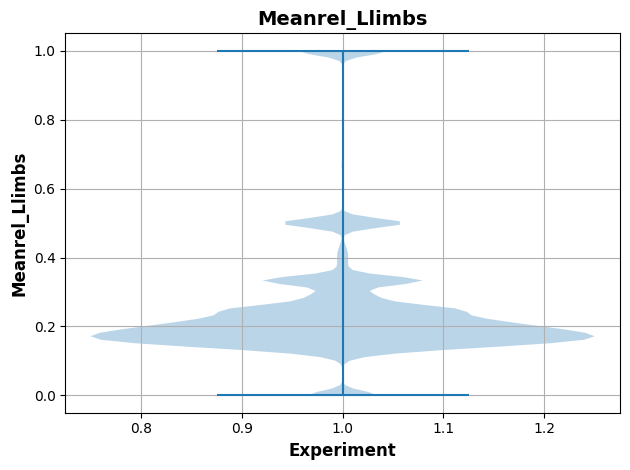

D:\AI\Random\Random\Morphologies\plots\violin\all\stdrel_llimbs.png


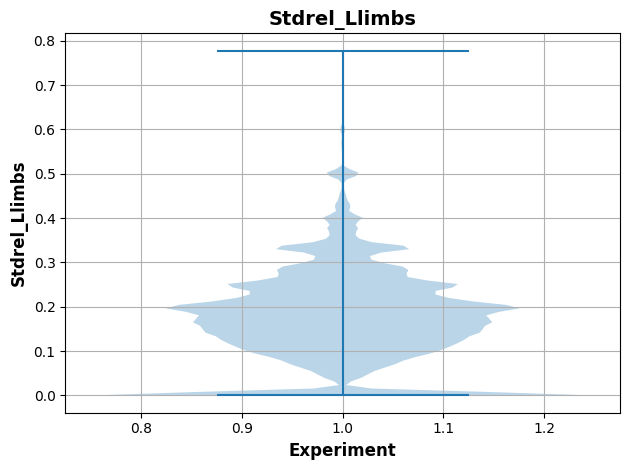

D:\AI\Random\Random\Morphologies\plots\violin\all\nlimbs.png


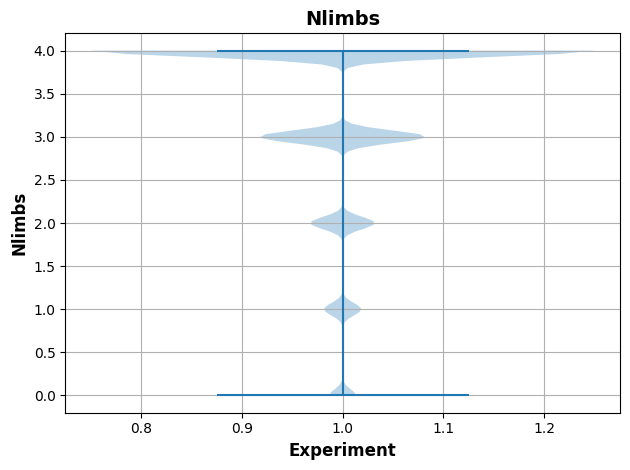

D:\AI\Random\Random\Morphologies\plots\violin\all\joints.png


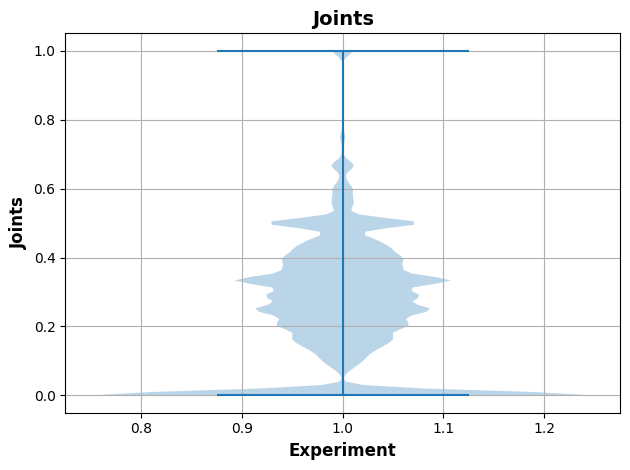

D:\AI\Random\Random\Morphologies\plots\violin\all\joint_brick_ratio.png


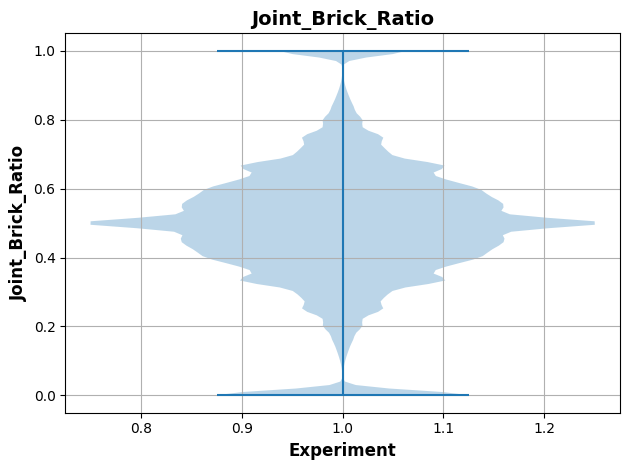

D:\AI\Random\Random\Morphologies\plots\violin\all\coverage.png


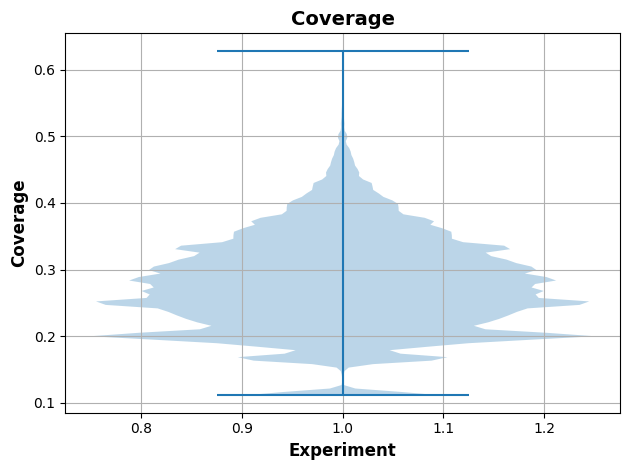

D:\AI\Random\Random\Morphologies\plots\violin\all\branching.png


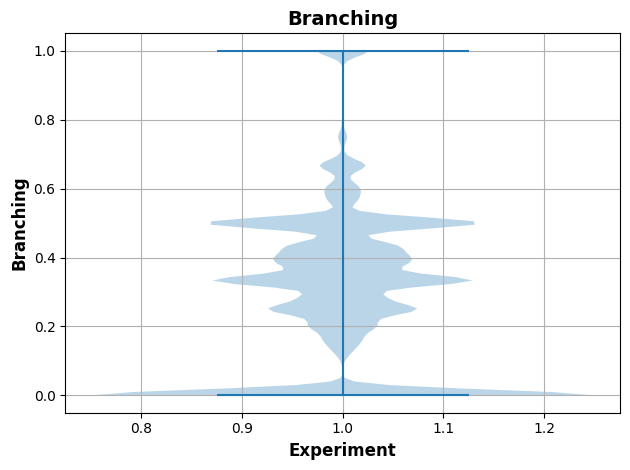

D:\AI\Random\Random\Morphologies\plots\violin\all\surface_area.png


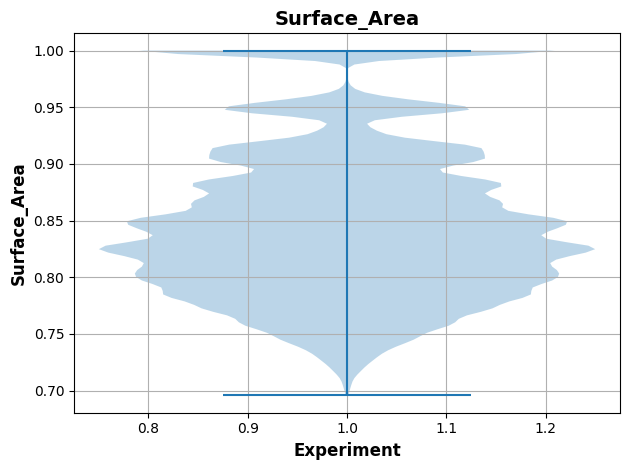

D:\AI\Random\Random\Morphologies\plots\violin\all\count.png


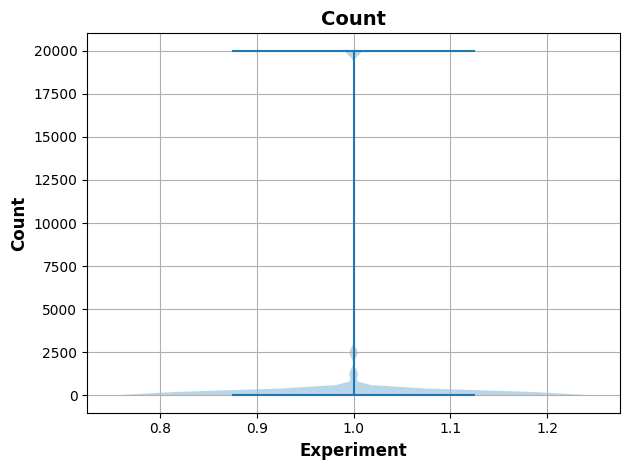

IndexingError: Too many indexers

In [6]:
for type_run in ["all", "unique"]:
    # ---- Create directory for violin plots
    path4plots = f"{path}\\Morphologies\\plots\\violin\\{type_run}"
    if not os.path.exists(path4plots):
        os.makedirs(path4plots)

    # ---- Duplicate values?
    if type_run == "unique":
        pass
    elif type_run == "all":
        dfnew = df.reindex(df.index.repeat(df.loc[:, "count"])).reset_index(drop=True)

    for col in columns2plot:
        # Get data for violin plot
        data4violin = []
        #for exp in df_exp["experiment_id"].unique():
            #sub_df = df_exp.loc[df_exp["experiment_id"] == exp, [col, "generation_index"]]
        # Select subset of data --> unique bodies or all? + column
        if type_run == "unique":
            sub_df = df.loc[:, col]
        else:
            sub_df = dfnew.loc[:, col]

        data4violin.append(sub_df)

        # Group data
        # Plot
        plt.violinplot(data4violin)
        plt.xlabel("Experiment", fontsize = 12, fontweight = 'bold')
        plt.ylabel(col.title(), fontsize = 12, fontweight = 'bold')
        plt.title(col.title(), fontsize = 14, fontweight = 'bold')
        plt.tight_layout()
        plt.grid()
        print(path4plots + f"\\{col}.png")
        #plt.savefig(path4plots + f"\\{col}.png")
        #plt.close()
        plt.show()

# Generate Histograms

Saving:  bricks
Minimum:  0
Maximum:  25


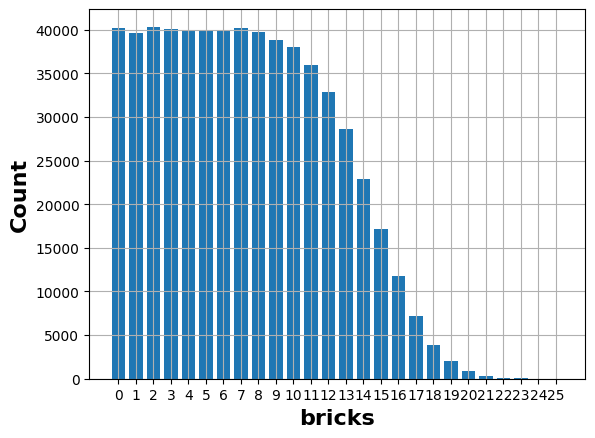

Saving:  hinges
Minimum:  0
Maximum:  25


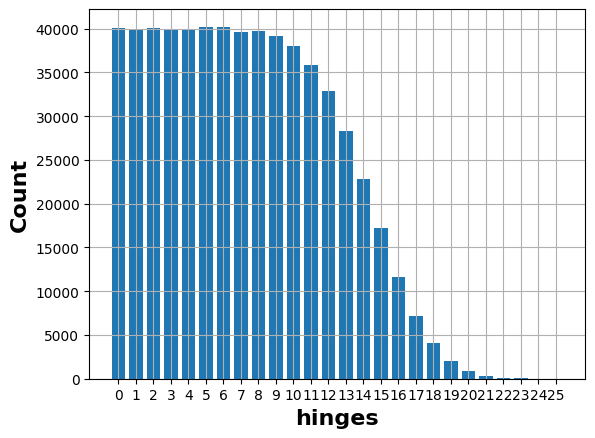

Saving:  modules
Minimum:  1
Maximum:  30


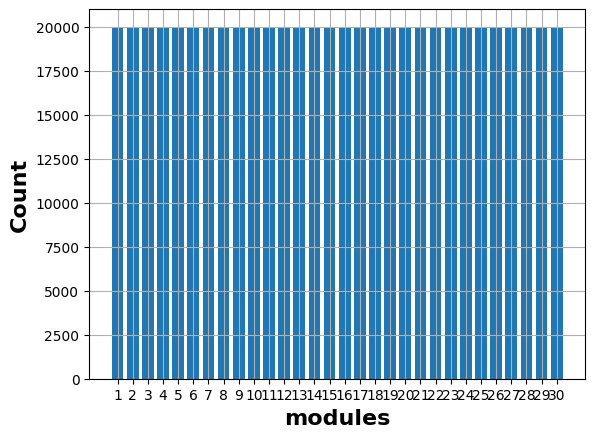

Saving:  size
Minimum:  0.0333333333333333
Maximum:  1.0


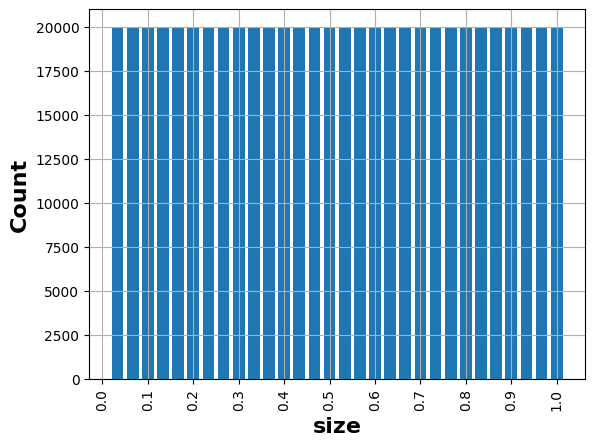

Saving:  proportion2d
Minimum:  0.2142857142857142
Maximum:  1.0


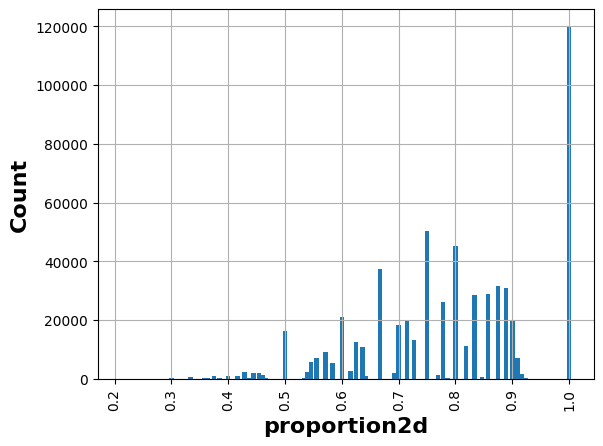

Saving:  proportionNiels
Minimum:  0.0
Maximum:  1.0


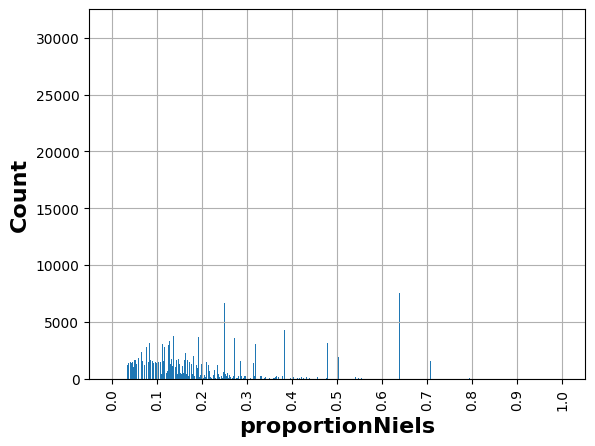

Saving:  single_neighbour_brick_ratio
Minimum:  0.0
Maximum:  1.0


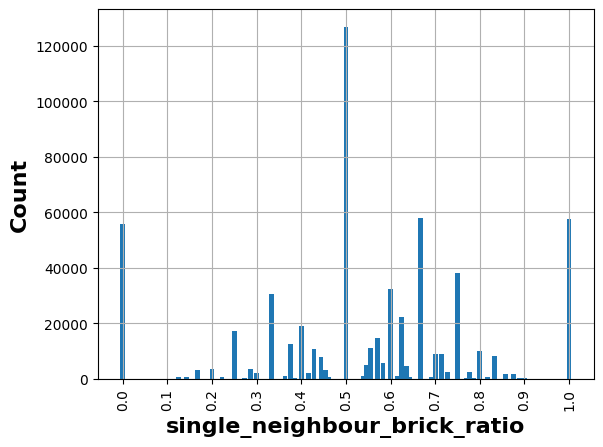

Saving:  single_neighbour_ratio
Minimum:  0.0
Maximum:  1.0


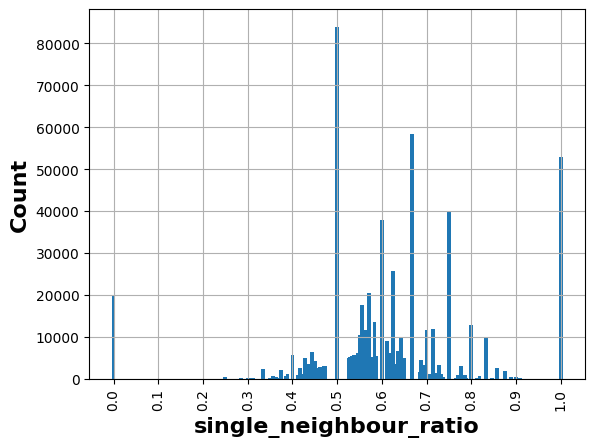

Saving:  double_neighbour_brick_and_active_hinge_ratio
Minimum:  0.0
Maximum:  1.0


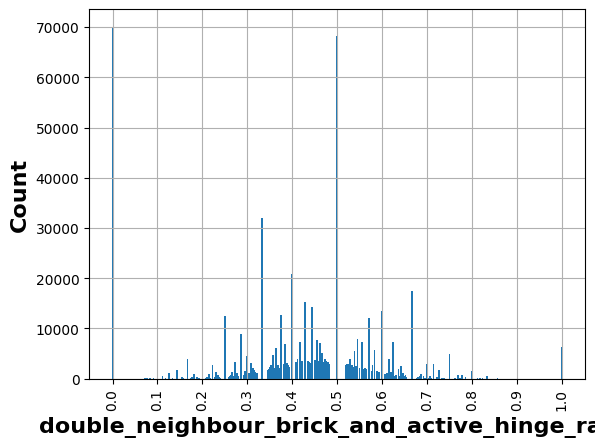

Saving:  maxrel_llimbs
Minimum:  0.0
Maximum:  1.0


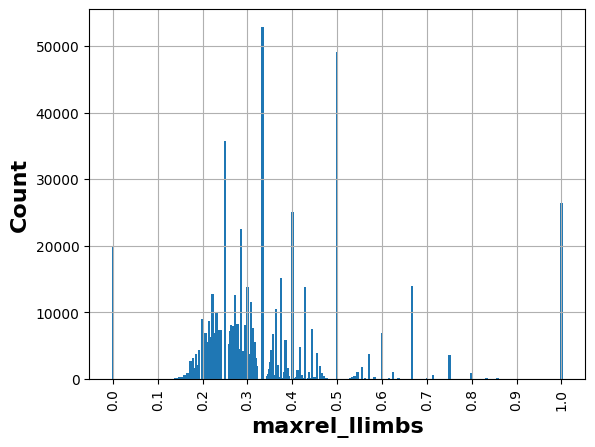

Saving:  meanrel_llimbs
Minimum:  0.0
Maximum:  1.0


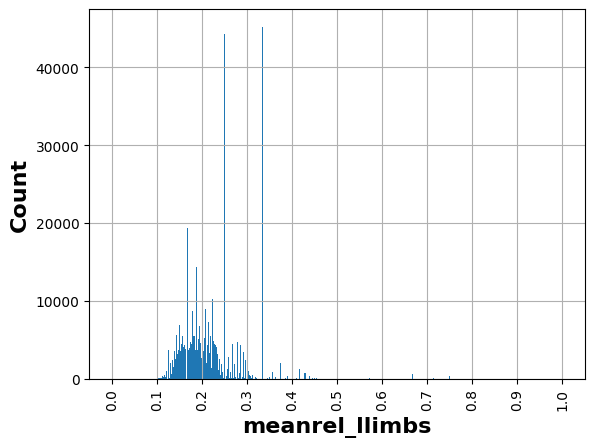

Saving:  stdrel_llimbs
Minimum:  0.0
Maximum:  0.7777777777777778


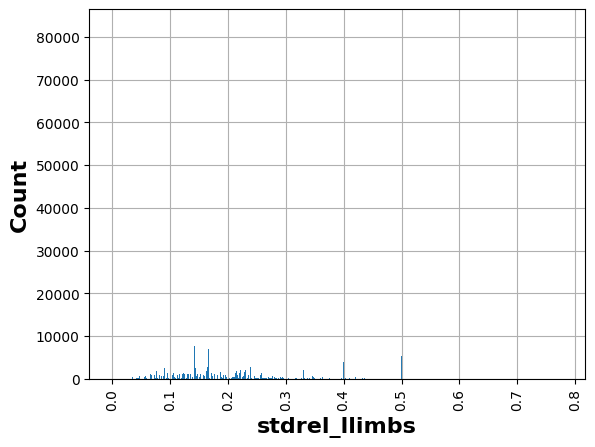

Saving:  nlimbs
Minimum:  0
Maximum:  4


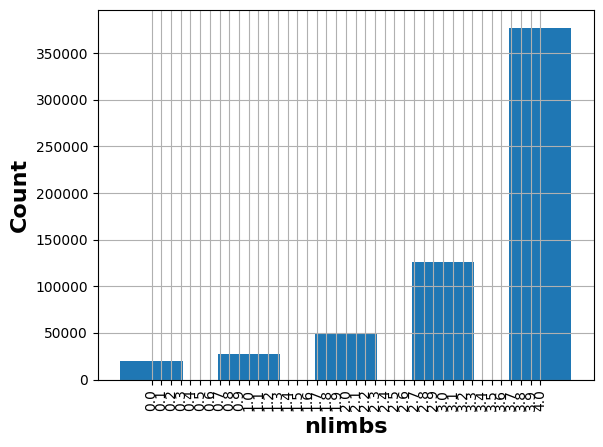

Saving:  joints
Minimum:  0.0
Maximum:  1.0


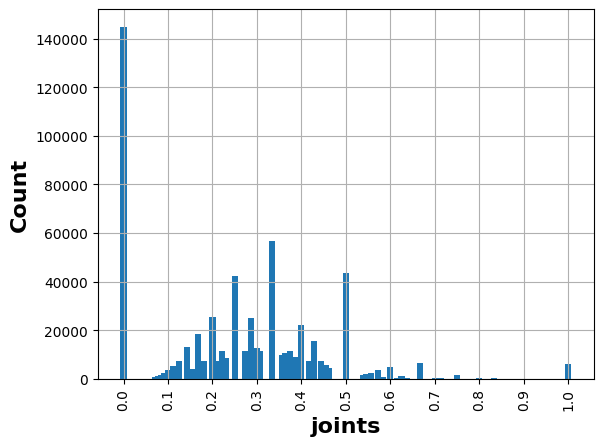

Saving:  joint_brick_ratio
Minimum:  0.0
Maximum:  1.0


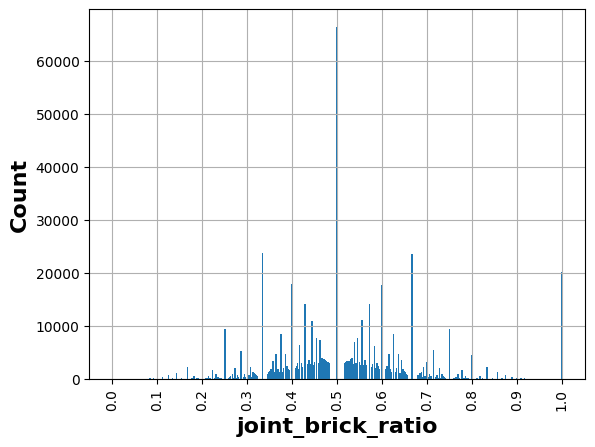

Saving:  symmetry_incl1
Minimum:  0.0
Maximum:  1.0


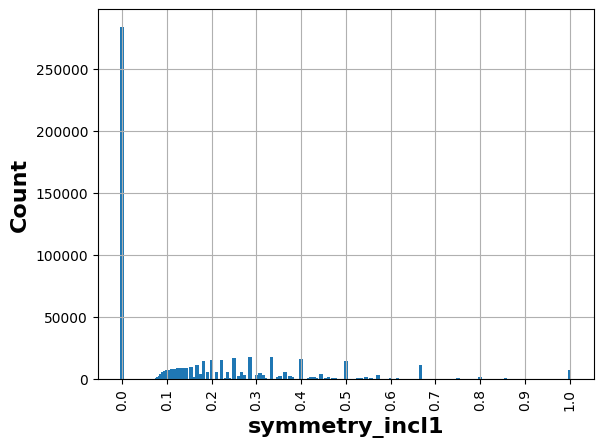

Saving:  symmetry_incl2
Minimum:  0.0
Maximum:  1.0


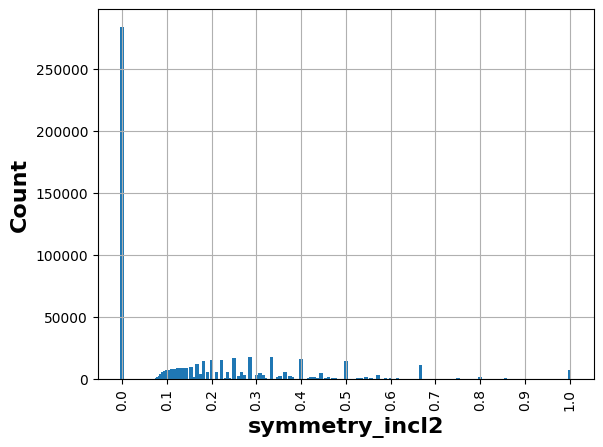

Saving:  symmetry_incl3
Minimum:  0.0
Maximum:  1.0


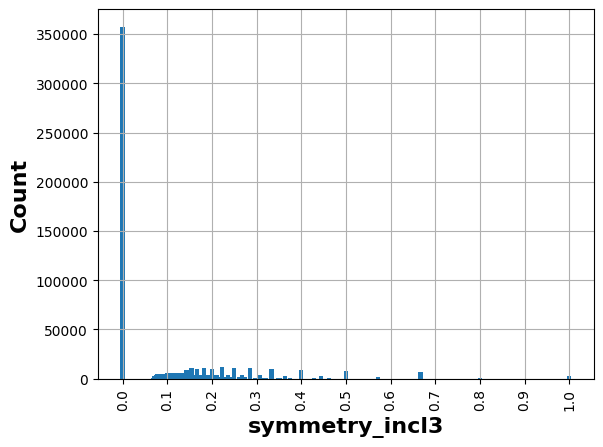

Saving:  symmetry_incl4
Minimum:  0.0
Maximum:  1.0


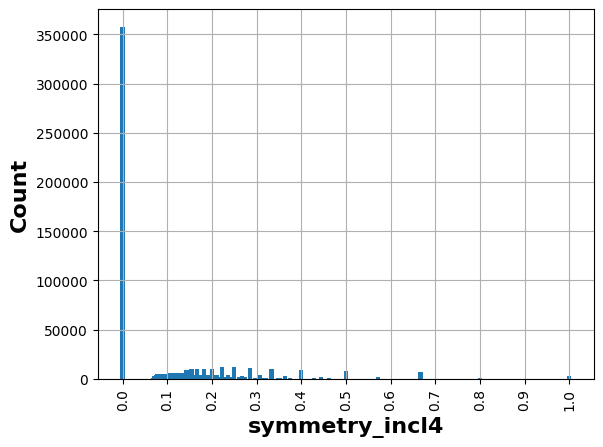

Saving:  symmetry_excl1
Minimum:  0.0
Maximum:  1.0


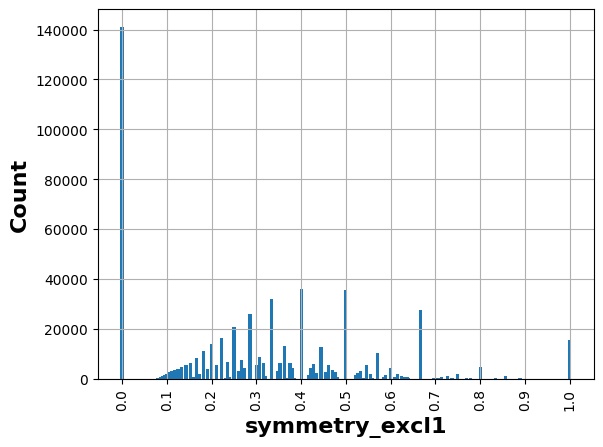

Saving:  symmetry_excl2
Minimum:  0.0
Maximum:  1.0


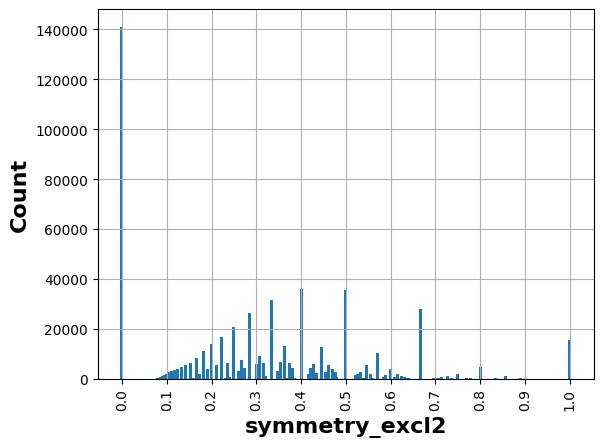

Saving:  symmetry_excl3
Minimum:  0.0
Maximum:  1.0


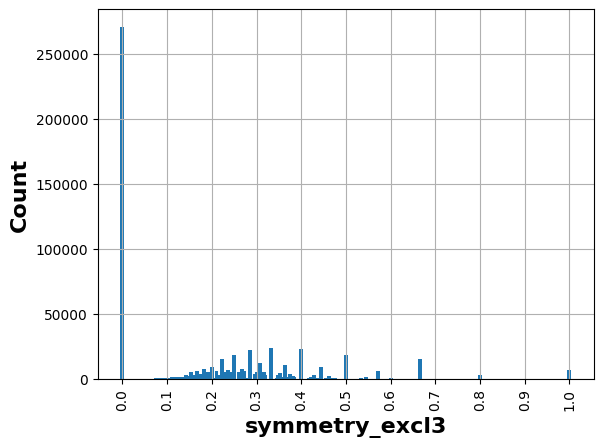

Saving:  symmetry_excl4
Minimum:  0.0
Maximum:  1.0


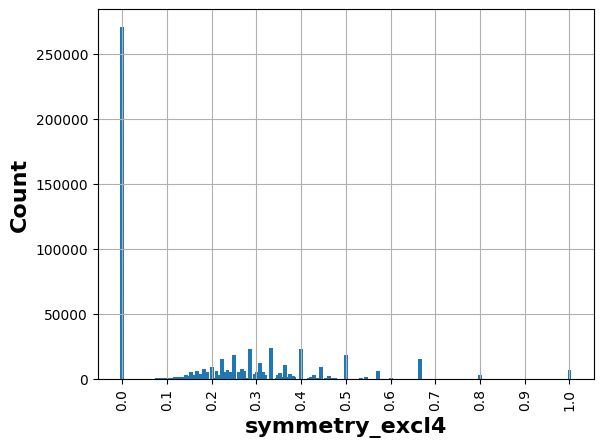

Saving:  coverage
Minimum:  0.1111111111111111
Maximum:  0.6285714285714286


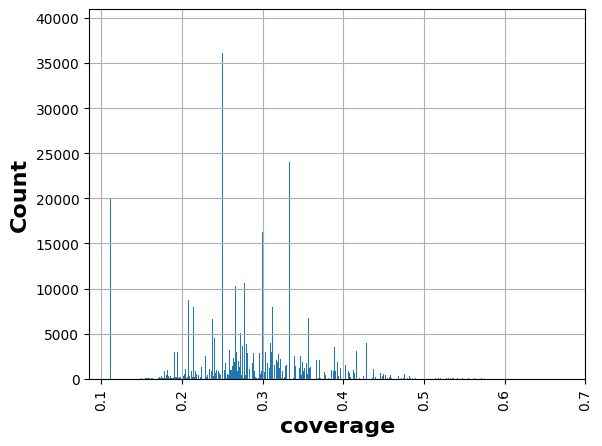

Saving:  branching
Minimum:  0.0
Maximum:  1.0


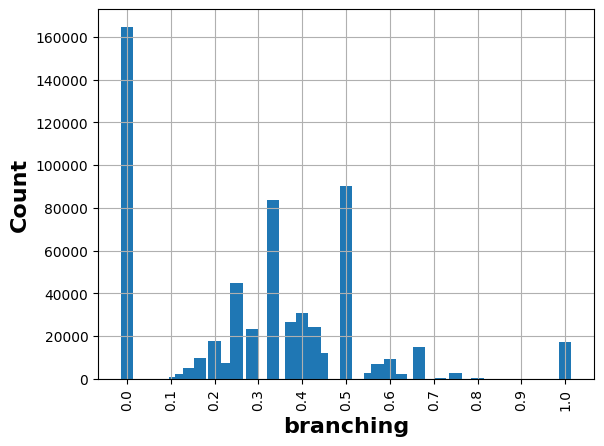

Saving:  surface_area
Minimum:  0.6956521739130435
Maximum:  1.0


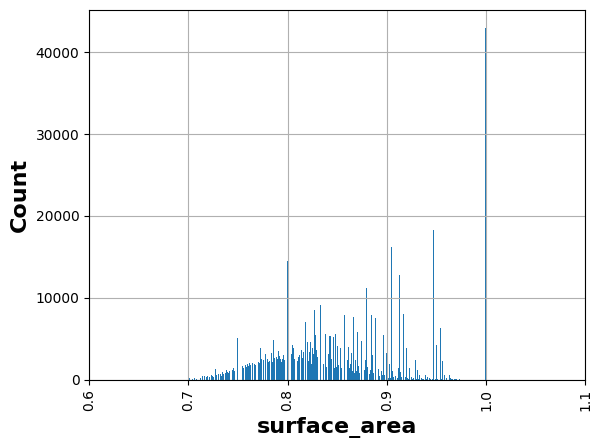

In [8]:
for col in cols2plot:
    # Get the data
    grouped_data = df.groupby([col])["count"].sum()
    # Plot
    width = (grouped_data.index.max() - grouped_data.index.min()) / len(grouped_data.index) * 0.8
    plt.bar(grouped_data.index, grouped_data.values, width = width, align = "center")
    plt.xlabel(col, fontsize = 16, fontweight = "bold")
    plt.ylabel("Count", fontsize = 16, fontweight = "bold")

    # Set ticks
    if col in ["bricks", "hinges", "modules"]:
        xt = np.arange(grouped_data.index.min(), grouped_data.index.max() + 1, 1)
        plt.xticks(ticks = xt, labels = xt)
    else:
        xt = np.arange(np.floor(grouped_data.index.min() * 10) / 10, np.ceil(grouped_data.index.max() * 10) / 10 + 0.1, 0.1)
        xt = [round(x, 2) for x in xt]
        plt.xticks(ticks = xt, labels = xt, rotation = 90)
    plt.grid()
    # Print
    print("Saving: ", col)
    print("Minimum: ", grouped_data.index.min())
    print("Maximum: ", grouped_data.index.max())
    # Save
    #plt.savefig(f"Morphology/Histograms/{col}.png")
    plt.show()
    # Close
    #plt.close()

# Plot Scatter of Unique Counts

In [ ]:
# Settings
logarithmics = [True, False]
for logarithmic in logarithmics:
    # Plot
    for icol1, col1 in enumerate(cols2plot):
        for col2 in cols2plot[icol1 + 1:]:
            # Set theme
            sns.set_theme(style="whitegrid")
            print(f"Saving {col1}_{col2}")
            # Unique counts --> i.e. unique combinations at that location
            x = (df.loc[:, col1] - df.loc[:, col1].min()) / (df.loc[:, col1].max() - df.loc[:, col1].min())
            y = (df.loc[:, col2] - df.loc[:, col2].min()) / (df.loc[:, col2].max() - df.loc[:, col2].min())
            counts = df.groupby([col1, col2]).transform("size")
            if logarithmic:
                counts = np.log(counts + 1) # Logarithmic scale
            counts.rename("Unique Count", inplace = True)
            #counts = (counts - counts.mean()) / (counts.std())
            counts_nonunique = df.groupby([col1, col2])["count"].transform("sum")
            if logarithmic:
                counts_nonunique = np.log(counts_nonunique + 1) # Logarithmic scale
            counts_nonunique.rename("Nonunique Count", inplace = True)
            #counts_nonunique = (counts_nonunique - counts_nonunique.mean()) / counts_nonunique.std()

            # Draw each cell as a scatter point with varying size and color
            g = sns.relplot(
                x=x, y=y, hue = counts,
                size = counts_nonunique,
                palette="vlag",
                edgecolor=".7",
                height=10, sizes=(50, 250),
                size_norm=(counts_nonunique.min(), counts_nonunique.max()),
                hue_norm=(counts.min(), counts.max()))

            # Tweak the figure to finalize
            g.set(xlabel = col1, ylabel = col2, aspect = "equal")
            g.despine(left=True, bottom=True)
            g.ax.margins(.02)
            for label in g.ax.get_xticklabels():
                label.set_rotation(90)

            # Save
            if logarithmic:
                plt.savefig(f"Morphology/ScatterUnique/log/{col1}_{col2}.png")
            else:
                plt.savefig(f"Morphology/ScatterUnique/nonlog/{col1}_{col2}.png")
            # Close
            plt.close()

Saving bricks_hinges
Saving bricks_modules
Saving bricks_size
Saving bricks_proportion2d
Saving bricks_proportionNiels
Saving bricks_single_neighbour_brick_ratio
Saving bricks_single_neighbour_ratio
Saving bricks_double_neighbour_brick_and_active_hinge_ratio
Saving bricks_maxrel_llimbs
Saving bricks_meanrel_llimbs
Saving bricks_stdrel_llimbs
Saving bricks_nlimbs
Saving bricks_joints
Saving bricks_joint_brick_ratio
Saving bricks_symmetry_incl1
Saving bricks_symmetry_incl2
Saving bricks_symmetry_incl3
Saving bricks_symmetry_incl4
Saving bricks_symmetry_excl1
Saving bricks_symmetry_excl2
Saving bricks_symmetry_excl3
Saving bricks_symmetry_excl4
Saving bricks_coverage
Saving bricks_branching
Saving bricks_surface_area
Saving hinges_modules
Saving hinges_size
Saving hinges_proportion2d
Saving hinges_proportionNiels
Saving hinges_single_neighbour_brick_ratio
Saving hinges_single_neighbour_ratio
Saving hinges_double_neighbour_brick_and_active_hinge_ratio
Saving hinges_maxrel_llimbs
Saving hin

# Grids

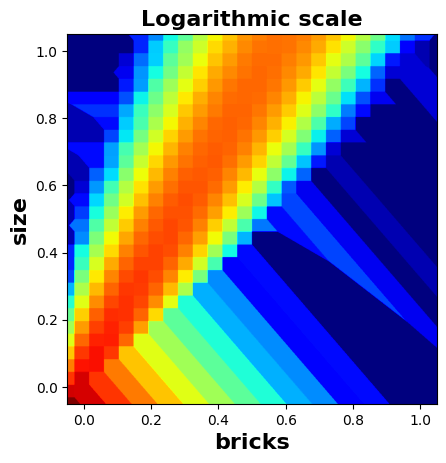

In [37]:
from scipy.interpolate import griddata

col1 = "bricks"
col2 = "size"
logarithmic = True
unique = False

# Get points
points = (df.loc[:, [col1, col2]] - df.loc[:, [col1, col2]].min(axis = 0)) / (df.loc[:, [col1, col2]].max(axis = 0) - df.loc[:, [col1, col2]].min(axis = 0))
if unique:
    points["values"] = df.groupby([col1, col2]).transform("size") # Unique counts
else:
    points["values"] = df.groupby([col1, col2])["count"].transform("sum") # Nonunique counts

# Drop duplicates
points = points.drop_duplicates([col1, col2])
values = points["values"].values
if logarithmic:
    values = np.log(values + 1) # Logarithmic scale
coordinates = points.loc[:, [col1, col2]].values

# Creat a meshgrid
mins = coordinates.min(axis = 0)
maxs = coordinates.max(axis = 0)
grid_x, grid_y = np.mgrid[mins[0]:maxs[0]:1000j, mins[1]:maxs[1]:1000j]

# Interpolate
grid_z0 = griddata(coordinates, values, (grid_x, grid_y), method='nearest', fill_value = 0) # nearest, linear, cubic

# Plot
plt.imshow(grid_z0.T, extent=(mins[0] - 0.05, maxs[0] + 0.05, mins[1] - 0.05, maxs[1] + 0.05), origin='lower', cmap = "jet")
#plt.scatter(coordinates[:, 0], coordinates[:, 1], c = "k")
plt.xlabel(col1, fontsize = 16, fontweight = "bold")
plt.ylabel(col2, fontsize = 16, fontweight = "bold")
if logarithmic:
    plt.title("Logarithmic scale", fontsize = 16, fontweight = "bold")
else:
    plt.title("Non-logarithmic scale", fontsize = 16, fontweight = "bold")
plt.show()

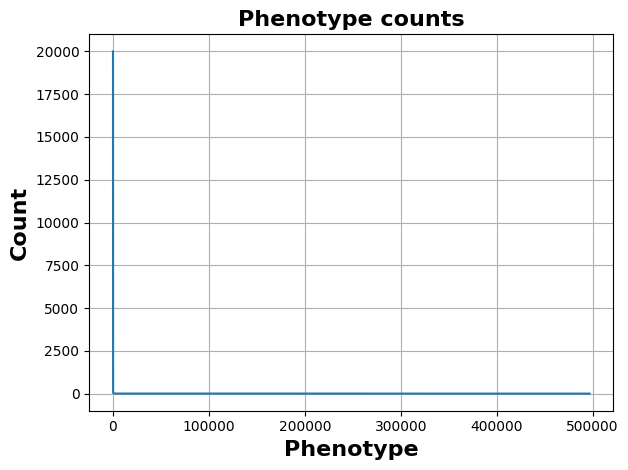

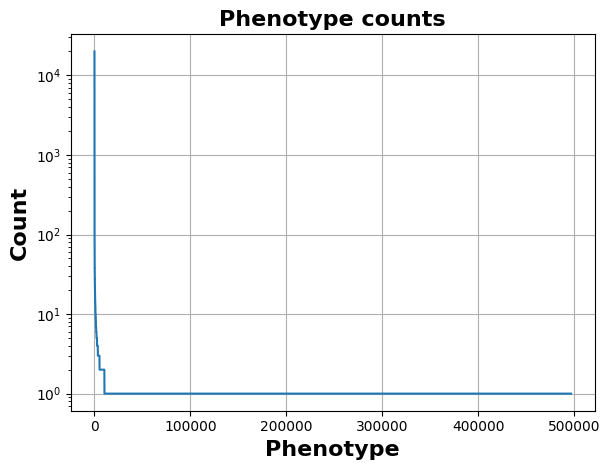

In [16]:
for type_scale in ["linear", "log"]:
    # Get counts of id_strings, sort by count and plot
    phenotype_counts = df.loc[:, "count"]
    sorted_phenotype_counts = phenotype_counts.sort_values(ascending = False).reset_index(drop = True)
    plt.plot(sorted_phenotype_counts, "-")
    plt.xlabel("Phenotype", fontsize = 16, fontweight = 'bold')
    plt.ylabel("Count", fontsize = 16, fontweight = 'bold')
    plt.title("Phenotype counts", fontsize = 16, fontweight = 'bold')
    plt.grid()
    plt.tight_layout()
    plt.yscale(type_scale)
    #plt.savefig(path4plots + f"\\phenotype counts_{type_scale}.png")
    plt.show()
